In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from scipy.special import kl_div

In [3]:
train = pd.read_csv("UNSW_NB15_training-set.csv", index_col=0)
test = pd.read_csv("UNSW_NB15_testing-set.csv", index_col=0)

In [4]:
data = pd.concat([train, test],ignore_index=False)

In [5]:
label = data.label.to_numpy()

In [6]:
data.drop(columns="label", inplace=True)

## Data Preprocessing


In [7]:
from sklearn.preprocessing import RobustScaler

In [8]:
cat_features = list(data.columns[data.dtypes == object])

(array([ 0.,  0.,  0.,  0.,  0., 43.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

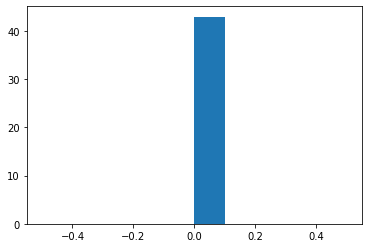

In [9]:
plt.hist(data.isna().sum(0))

In [10]:
cardinalities = []

for cat_feature in data.columns:
#     print(cat_feature)
    cardinalities.append(len(data[cat_feature].value_counts()))
cardinalities = np.array(cardinalities)

(array([30.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0., 10.]),
 array([2.000000e+00, 1.213740e+04, 2.427280e+04, 3.640820e+04,
        4.854360e+04, 6.067900e+04, 7.281440e+04, 8.494980e+04,
        9.708520e+04, 1.092206e+05, 1.213560e+05]),
 <BarContainer object of 10 artists>)

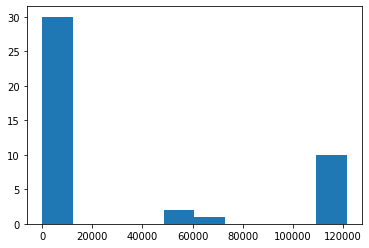

In [11]:
plt.hist(cardinalities)

In [12]:
onehoted_data = pd.get_dummies(data, columns=cat_features)

In [13]:
scaler = RobustScaler()

In [14]:
normalized_data = scaler.fit_transform(onehoted_data)

In [15]:
train_normalized = normalized_data[train.index - 1]
test_normalized = normalized_data[train.shape[0] + test.index - 1]

train_label = label[train.index - 1]
test_label = label[train.shape[0] + test.index - 1]

# CGAN

In [16]:
import torch
from torch import nn

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, input_size):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.input_size = input_size
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim + self.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            nn.Linear(512, self.input_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_embedding(labels), noise), -1)
        out = self.model(gen_input)
#         img = img.view(img.size(0), *img_shape)
        return out

In [19]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, input_size):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.label_embedding = nn.Embedding(self.n_classes, self.n_classes)

        self.model = nn.Sequential(
            nn.Linear(self.n_classes + self.input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, input, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((input, self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [20]:
n_epochs = 100

n_classes = 2
input_size = normalized_data.shape[1]
latent_dim = int(np.sqrt(input_size))

batchSize = 10000

print(n_classes, input_size, latent_dim)

# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator(n_classes, latent_dim, input_size).to(device)
discriminator = Discriminator(n_classes, input_size).to(device)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0005)

2 206 14


In [21]:
from torch.autograd import Variable 
FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available()  else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available()  else torch.LongTensor

In [22]:
#Create a random dataset
dataset = TensorDataset(torch.tensor(normalized_data).float(), 
                        torch.tensor(label).float())

data_loader = DataLoader(dataset, 
                         batch_size=batchSize,
                         shuffle=True)

In [23]:
losses = []
kl_divs = []
for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    epoch_kl_divs = []
    for i, (input_, target) in enumerate(data_loader):
        input_ = Variable(input_.type(FloatTensor)).to(device)
        target = Variable(target.type(LongTensor)).to(device)

        batch_size = input_.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes,batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(input_, target)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_losses.append(g_loss.item() + d_loss.item())
        epoch_kl_divs.append(F.kl_div(gen_imgs.detach().cpu(), input_.detach().cpu()))
        
    losses.append(np.mean(epoch_losses))
    kl_divs.append(np.mean(epoch_kl_divs))

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2722: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


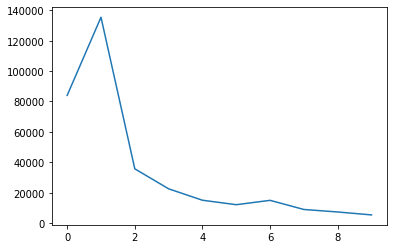

In [24]:
plt.plot(losses)

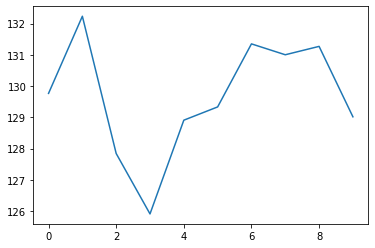

In [25]:
plt.plot(kl_divs)

In [212]:
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')

In [42]:
generator = torch.load('generator.pth')
discriminator = torch.load('discriminator.pth')

# Classification Models


## Balance data

In [26]:
np.unique(train_label, return_counts=True)

(array([0, 1]), array([37000, 45332]))

In [27]:
n_disbalanced = 45332 - 37000
n_disbalanced

8332

In [28]:
# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (n_disbalanced, latent_dim))))
gen_labels = Variable(LongTensor(np.zeros(n_disbalanced)))

with torch.no_grad():
    # Generate a batch of images
    gen_outputs = generator(z, gen_labels).cpu().numpy()

In [31]:
extended_train_x = np.vstack((train_normalized, gen_outputs))
extended_train_y = np.hstack((train_label, np.zeros(n_disbalanced)))

In [32]:
np.unique(extended_train_y, return_counts=True)

(array([0., 1.]), array([45332, 45332]))

## Classifiers

In [33]:
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [34]:
classifiers = {
#                 "forest": RandomForestClassifier(), 
#                "boosting": ExplainableBoostingClassifier(),
               "nn": MLPClassifier(hidden_layer_sizes=(207))}

## Performance Metric

In [306]:
from sklearn.metrics import classification_report

### Use original data

In [320]:
for method, classifier in classifiers.items():
    print(method)
    classifier.fit(train_normalized, train_label)
    y_pred = classifier.predict(test_normalized)
    print(classification_report(test_label, y_pred))

nn
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56000
           1       1.00      0.99      1.00    119341

    accuracy                           1.00    175341
   macro avg       0.99      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



### Use extended data

In [318]:
for method, classifier in classifiers.items():
    print(method)
    classifier.fit(extended_train_x, extended_train_y)
    y_pred = classifier.predict(test_normalized)
    print(classification_report(test_label, y_pred))

nn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



## Cross validation

In [36]:
from sklearn.model_selection import cross_validate

In [31]:
for method, classifier in classifiers.items():
    print(method)

    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=classifier,
                               X=extended_train_x,
                               y=extended_train_y,
                               cv=5,
                               scoring=scoring,
                               return_train_score=True)
    
    print(results)

nn
{'fit_time': array([54.33321404, 20.56248045, 17.88961792, 22.2266748 , 48.55841017]), 'score_time': array([0.04326701, 0.29311085, 0.03644252, 0.03950834, 0.04197192]), 'test_accuracy': array([0.99441307, 0.99502034, 0.99653832, 0.99495931, 0.9982388 ]), 'train_accuracy': array([0.99767707, 0.9983451 , 0.99669025, 0.98035405, 0.99710017]), 'test_precision': array([1.        , 0.99146702, 0.99516324, 0.99178802, 0.99724882]), 'train_precision': array([0.99994462, 0.9974136 , 0.99554602, 0.96572205, 0.99977834]), 'test_recall': array([0.98985331, 0.99955884, 0.99856607, 0.99911758, 0.99955879]), 'train_recall': array([0.99583621, 0.99958638, 0.99845585, 0.99980698, 0.99495395]), 'test_f1': array([0.99490079, 0.99549649, 0.99686175, 0.99543931, 0.99840247]), 'train_f1': array([0.99788619, 0.99849881, 0.99699882, 0.98246898, 0.99736031])}


In [37]:
for method, classifier in classifiers.items():
    print(method)

    scoring = ['accuracy', 'precision', 'recall', 'f1']
    extended_results = cross_validate(estimator=classifier,
                               X=train_normalized,
                               y=train_label,
                               cv=5,
                               scoring=scoring,
                               return_train_score=True)
    
    print(extended_results)

nn
{'fit_time': array([27.52121902, 71.839185  , 25.95224714, 66.57144547, 21.32277608]), 'score_time': array([0.12408805, 0.16644597, 0.09846258, 0.09616089, 0.09694743]), 'test_accuracy': array([0.97044063, 0.9941543 , 0.99503667, 0.99856615, 0.80879109]), 'train_accuracy': array([0.98909432, 0.99889702, 0.99583626, 0.99947609, 0.99647052]), 'test_precision': array([0.94687762, 0.99036778, 1.        , 0.99790726, 0.72369157]), 'train_precision': array([0.97873202, 0.99790853, 0.9998888 , 0.99969654, 0.99994447]), 'test_recall': array([0.99680124, 0.99801456, 0.99007389, 0.99922797, 0.99900728]), 'train_recall': array([0.99991728, 0.9998897 , 0.99178271, 0.99925548, 0.99299619]), 'test_f1': array([0.97119828, 0.99417646, 0.99501219, 0.99856718, 0.83934943]), 'train_f1': array([0.98921123, 0.99889813, 0.99581926, 0.99947596, 0.99645822])}
